In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## restrict to wordy posts

df = pd.read_csv("train_test_data_v1.csv")
df = df.loc[(df.title_len > df.title_len.quantile(.66)) | (df.body_len > 0)]
df.count()

Unnamed: 0            60
title_len             60
body_len              60
upvote_ratio          60
time                  60
compound_score        60
num_early_comments    60
num_comments          60
num_top_comments      60
score                 60
dtype: int64

We make an outputs dataframe, and set a "principal" score, which is the principal axis from the PCA on these 3 features.

In [3]:
outputs = df[['score', 'num_comments', 'upvote_ratio']].astype(float)

In [4]:
outputs["norm_score"] = (outputs.score - outputs.score.mean()) / outputs.score.std()
outputs["norm_comments"] = (outputs.num_comments - outputs.num_comments.mean()) / outputs.num_comments.std()
outputs["norm_ratio"] = (outputs.upvote_ratio - outputs.upvote_ratio.mean()) / outputs.upvote_ratio.std()

outputs_final = outputs[['norm_score', 'norm_comments', 'norm_ratio']]
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
pca.fit(outputs_final)

pca.components_

array([[ 0.65780786,  0.54111587,  0.52391072],
       [ 0.01669115,  0.68494911, -0.72839969],
       [-0.75300081,  0.48789172,  0.44153306]])

In [5]:
outputs["principal"] = pca.components_[0][0]*outputs.norm_score + pca.components_[0][1]*outputs.norm_comments + pca.components_[0][2]*outputs.norm_ratio 

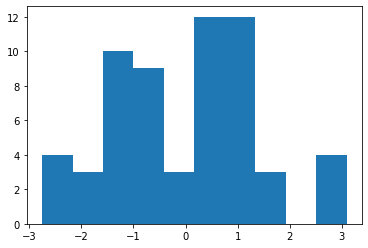

In [6]:
outputs_copy = outputs.copy()
df["principal"] = outputs_copy.principal
plt.hist(df.principal)
plt.show()

In [7]:
df.corr()['principal'].sort_values()

body_len             -0.373785
num_top_comments     -0.343115
compound_score       -0.299737
time                  0.147760
title_len             0.217916
num_early_comments    0.553615
upvote_ratio          0.711290
num_comments          0.734649
score                 0.893076
principal             1.000000
Name: principal, dtype: float64

We shrink the time values because they give my computer a headache.

In [8]:
## df['small_times'] = df.time_created/1000000

## plt.hist(df['score'])

We regress against time, because we don't want to be biased towards older posts.

In [9]:
## from sklearn.linear_model import LinearRegression

## slr = LinearRegression(copy_X = True)

## slr.fit(df['small_times'].values.reshape(-1,1), df['principal'].values)

Our final output variable is called popularity_score.

In [10]:
##b0 = slr.intercept_
## b1 = slr.coef_[0]

## df['popularity_score'] = df.principal - b0 - b1 * df.small_times

## define the classifiation here, check what proportion of posts are "good"
df['class'] = df['principal'] > (df['principal'].mean()+0.0*df['principal'].std()) 
df['class'] = df['class'].astype(int)
df['class'].mean()

0.5333333333333333

In [11]:
## code from K Nearest Neighbors Lecture, measuring accuracy of model
def get_acc(model,X,y):
    pred = model.predict(X)
    return np.sum(pred == y)/len(y)


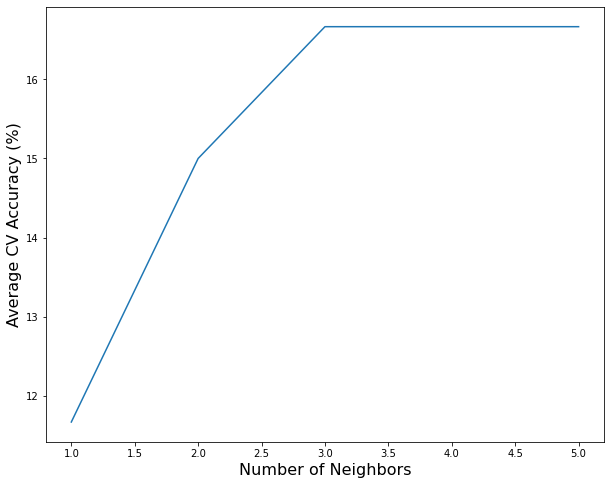

In [12]:
## KNN implementation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
## define data

kfold = StratifiedKFold(5,shuffle = True,random_state = 440)

max_neighbors = 5

X = df[['num_early_comments','body_len','compound_score','title_len']].to_numpy()
y = df[['class']].to_numpy()


## Make an empty array to hold your cv accuracies here
accuracy = np.zeros((5,max_neighbors))

for train_index, test_index in kfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    i = 0;
    j = 0
    for i in range (0,max_neighbors):
        knn = KNeighborsClassifier(n_neighbors = i+1)
        knn.fit(X_train,y_train.ravel())
        accuracy[j][i] = get_acc(knn,X_test,y_test.ravel())
        i = i+1
    j = j+1

#Plot how the accuracy changes

plt.figure(figsize=(10,8))

## Plot the number of neighbors on the x
## plot the avg cross validation accuracy on the y
plt.plot(np.linspace(1,max_neighbors,num=max_neighbors),100*np.mean(accuracy,axis=0))

## Use these as your axes labels
plt.xlabel("Number of Neighbors", fontsize=16)
plt.ylabel("Average CV Accuracy (%)", fontsize=16)

plt.show()

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=6)

clf = RandomForestClassifier(max_depth = 4, random_state=614)

clf.fit(X_train,y_train.ravel())

100*get_acc(clf,X_test,y_test.ravel())



100.0

In [19]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

X_train, X_test0, y_train, y_test0 = train_test_split(X, y, 
                                                    test_size=0.5, 
                                                    random_state=9)
tree_clf = DecisionTreeClassifier(random_state = 100,max_depth=2)

plt.figure(figsize = (20,20))

## Plot the fitted tree
fig = tree_clf.fit(X_train, y_train)
## tree.plot_tree(fig,filled = True,max_depth=1)
## plt.show()
print(100*get_acc(fig,X_test0,y_test0.ravel()))

confusion_matrix(y_test, fig.predict(X_test))

83.33333333333334


array([[14,  2],
       [ 3, 11]])

<Figure size 1440x1440 with 0 Axes>

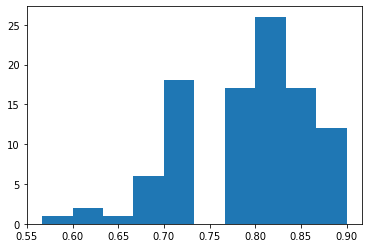

0.78

In [21]:
n=100
accuracy = np.zeros(n)
fig = tree_clf.fit(X_train, y_train)
for i in range(0,n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.5, 
                                                    random_state=i)
    fig = tree_clf.fit(X_train, y_train)
    accuracy[i] = get_acc(fig,X_test,y_test.ravel())
plt.hist(accuracy)
plt.show()
accuracy.mean()